## <u> Gaussian Mixture Models Clustering Algorithm Explained </u>

Gaussian mixture models can be used to cluster unlabeled data in much the same way as k-means. There are, however, a couple of advantages to using Gaussian mixture models over k-means.

- k-means does not account for variance(width of the bell shape curve). In two dimensions, variance/ covariance determines the shape of the distribution.

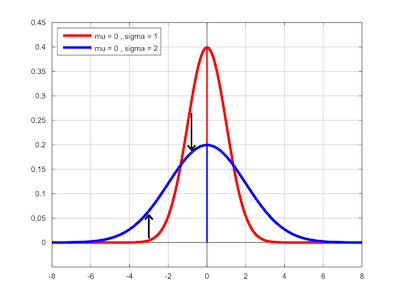

k-means model places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.

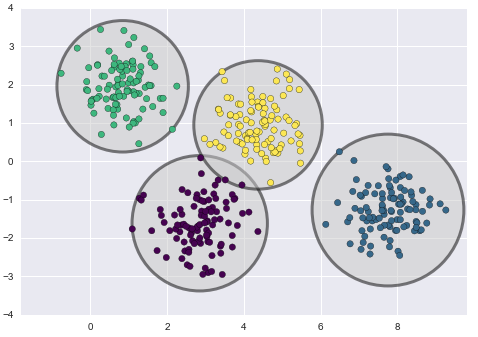

This works fine for when data is circular. However, when data takes on different shape, we end up with something like this.

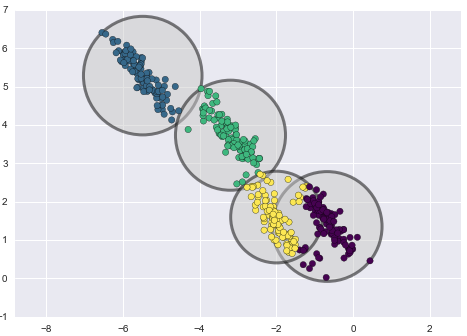

In contrast, Gaussian mixture models can handle even very oblong clusters.

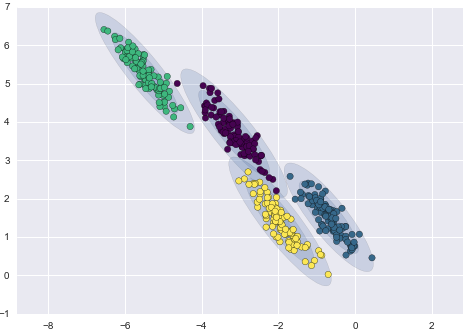

-  K-means performs hard classification whereas GMM performs soft classification, i.e. in k-means, data point is deterministically assigned to one and only one cluster, but in reality there may be overlapping between the cluster  GMM provide us the probabilities of the data point belonging to each of the possible clusters.

In Sklearn, $gmm.predict(X)$ the model assigns every data point to one of the clusters and $gmm.predict\_proba(X)$ function return the probabilities that a data point belongs to each of the K clusters.

Sklearn's GaussianMixture also comes with different options to constrain the covariance of the difference classes estimated: spherical, diagonal, tied or full covariance.

### <u>Gaussian Mixture Models At A Glance</u>

As the name implies, a Gaussian mixture model involves the mixture (i.e. superposition) of multiple Gaussian distributions. Here rather than identifying clusters by “nearest” centroids, we fit a set of k gaussians to the data. And we estimate gaussian distribution parameters such as mean and Variance for each cluster and weight of a cluster. After learning the parameters for each data point we can calculate the probabilities of it belonging to each of the clusters.

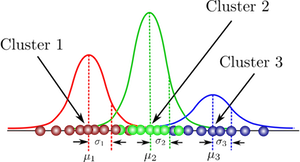

Every distribution is multiplied by a weight $\pi$($\pi_1 + \pi_2 + \pi_3 = 1$) to account for the fact that we do not have an equal number of samples from each category. In other words, we might only have included 1000 people from the red cluster class and 100,000 people from the green cluster class.

### <u>Expectation Maximization</u>

<b><u>Expectation</u></b>

The first step, known as the expectation step or $E$ step, consists of calculating the expectation of the component assignments $C_k$ for each data point $x_i \in X$ given the model parameters $\pi_k$ $\mu_k$ and $\sigma_k$.

<b><u>Maximization</u></b>

The second step is known as the maximization step or $M$ step, which consists of maximizing the expectations calculated in the E step with respect to the model parameters. This step consists of updating the values $\pi_k$, $\mu_k$ and $\sigma_k$.

The entire iterative process repeats until the algorithm converges, giving a maximum likelihood estimate. Intuitively, the algorithm works because knowing the component assignment $C_k$ for each $x_i$ makes solving for $\pi_k$ $\mu_k$ and $\sigma_k$ easy, while knowing $\pi_k$ $\mu_k$  $\sigma_k$ makes inferring $p(C_k|x_i)$ easy. The expectation step corresponds to the latter case while the maximization step corresponds to the former. Thus, by alternating between which values are assumed fixed, or known, maximum likelihood estimates of the non-fixed values can be calculated in an efficient manner.

### <u>Algorithm</u>
- Initialize the mean $\mu_k$, the covariance matrix $\Sigma_k$ and the mixing coefficients $\pi_k$ by some random values(or other values).
- Compute the $C_k$ values for all k.
- Again Estimate all the parameters using the current \C_k values.
- Compute log-likelihood function.
- Put some convergence criterion
- If the log-likelihood value converges to some value (or if all the parameters converge to some values) then stop, else return to Step 2.

This algorithm only guarantee that we land to a local optimal point, but it do not guarantee that this local optima is also the global one. And so, if the algorithm starts from different initialization points, in general it lands into different configurations.


### <u>Example</u>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
raw_df = pd.read_csv('../input/ccdata/CC GENERAL.csv')
raw_df = raw_df.drop('CUST_ID', axis = 1) 
raw_df.fillna(method ='ffill', inplace = True) 
raw_df.head(2)

In [ ]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

In [ ]:
gmm = GaussianMixture(n_components = 3) 
gmm.fit(X_principal)

In [ ]:
# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_components = 3).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

### <u>Number of components(k) selection</u>:

#### <u>Silhouette score</u>

Silhouette score checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is. Read more [here](https://www.kaggle.com/vipulgandhi/kmeans-detailed-explanation)

Since we already know that the fitting procedure is not deterministic, we run twenty fits for each number of clusters, then we consider the mean value and the standard deviation of the best five runs.

In [ ]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        labels=gmm.predict(X_principal)
        sil=metrics.silhouette_score(X_principal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

In [ ]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")


#### <u>Distance between GMMs</u>

Here we form two datasets, each with an half randomly choose amount of data. We will then check how much the GMMs trained on the two sets are similar, for each configuration.

Since we are talking about distributions, the concept of similarity is embedded in the Jensen-Shannon (JS) metric. The lesser is the JS-distance between the two GMMs, the more the GMMs agree on how to fit the data.

The lower the distance, the better the cluster.

In [ ]:
#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [ ]:
n_clusters=np.arange(2, 8)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X_principal, test_size=0.5)
        
        gmm_train=GaussianMixture(n, n_init=2).fit(train) 
        gmm_test=GaussianMixture(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

In [ ]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

<b><u>Bayesian information criterion (BIC)</u></b>

This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have. In order to avoid overfitting, this technique penalizes models with big number of clusters.

In [ ]:
n_clusters=np.arange(2, 8)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        
        tmp_bic.append(gmm.bic(X_principal))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

In [ ]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

Following this criterion, the bigger the number of clusters, the better should be the model. Which means that the penalty BIC criteria gives to complex models do not save us from overfit.

But before screaming and trashing out this technique, we can notice two things. The first is that the curve is fairly smooth and monotone. The second is that the curve follows different slopes in different part of it. Starting from these two observations, the temptation to check where the BIC curve change slope is big. So let’s check it!

Technically, we have to calculate the gradient of the BIC scores curve. Intuitively, the concept of gradient is simple: if two consecutive points have the same value, their gradient is zero. If they have different values, their gradient can be eighter negative, if the second point has a lower value, or positive otherwise. The magnitude of the gradient tells us how much the two values are different.


In [ ]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()